In [ ]:
#driveへマウントする
from google.colab import drive
drive.mount('/content/drive')

#フォルダを移動する
%cd "drive/My Drive/DDPG"

%matplotlib inline

!apt update
!apt install xvfb
!pip install pyvirtualdisplay

!pip install tensorboard==1.15
!pip install tb-nightly

%load_ext tensorboard

from pyvirtualdisplay import Display
from gym.wrappers import Monitor

import matplotlib
import numpy as np
import gym
import torch
from DDPG_Agent import DdpgAgent
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import pyglet

import matplotlib.animation as animation
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DDPG
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-08-12 07:01:28.734668: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 289, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 305, in _run_serve_subcommand
    server = self._make_server()
  File "/usr/local/lib/python3

1000 Data collected
Episode 0 finished | Episode reward -1038.897843
Episode 0 finished | Average reward -1030.222712
Episode 1 finished | Episode reward -1082.102261
Episode 2 finished | Episode reward -500.625367
Episode 3 finished | Episode reward -347.100854
Episode 4 finished | Episode reward -522.666089
Episode 5 finished | Episode reward -524.897705
Episode 6 finished | Episode reward -281.614806
Episode 7 finished | Episode reward -200.352938
Episode 8 finished | Episode reward -97.902845
Episode 9 finished | Episode reward -303.470922
Episode 10 finished | Episode reward -346.934081
Episode 11 finished | Episode reward -417.180134
Episode 12 finished | Episode reward -489.162114
Episode 13 finished | Episode reward -436.154957
Episode 14 finished | Episode reward -317.441029
Episode 15 finished | Episode reward -153.696935
Episode 16 finished | Episode reward -150.031821
Episode 17 finished | Episode reward -134.460321
Episode 18 finished | Episode reward -156.706152
Episode 1

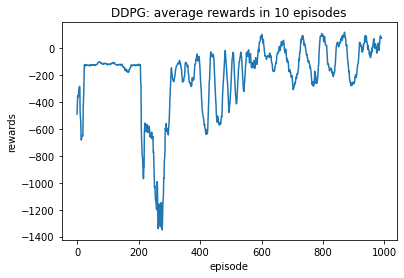

In [ ]:
%tensorboard --logdir='./runs'
!pip install box2d-py

gym.logger.set_level(40)
%matplotlib inline
from collections import deque
from GymWrapper import ImgWrapper
from util import layer_init
from Noise import ActionNoise

disp = Display(visible=0, size=(500,300))
_ = disp.start()

env = None
is_image = False
if is_image:
    env = ImgWrapper(gym.make('LunarLanderContinuous-v2'), gray_scale=True)
else:
    env = gym.make('LunarLanderContinuous-v2')
#検証用にシードを固定する
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
env.seed(42)


num_episode = 1000  # 学習エピソード数（学習に時間がかかるので短めにしています）
memory_size = 10000  # replay bufferの大きさ
initial_memory_size = 1000  # 最初に貯めるランダムな遷移の数
# ログ用の設定
episode_rewards = []
num_average_epidodes = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir='./runs')
max_steps = env.spec.max_episode_steps  # エピソードの最大ステップ数
agent = DdpgAgent(env.observation_space,
                  env.action_space,
                  device,
                  batch_size = 64,
                  memory_size=memory_size,
                  writer=writer,
                  is_image = is_image)

# 最初にreplay bufferにランダムな行動をしたときのデータを入れる
state = env.reset()
for step in range(initial_memory_size):
    action = env.action_space.sample() # ランダムに行動を選択 
    next_state, reward, done, _ = env.step(action)
    agent.memory.add(state, action, reward, done)
    state = env.reset() if done else next_state
print('%d Data collected' % (initial_memory_size))

for episode in range(num_episode):
    state = env.reset()  # envからは3次元の連続値の観測が返ってくる
    episode_reward = 0
    noise = ActionNoise(env.action_space.shape[0])
    for t in range(max_steps):
        action = agent.get_action(state, noise, t)  #  行動を選択
        next_state, reward, done, _ = env.step(action  * env.action_space.high)
        episode_reward += reward
        agent.memory.add(state, action, reward, done)
        agent.update()  # actorとcriticを更新
        state = next_state
        if done:
            break
    episode_rewards.append(episode_reward)
    writer.add_scalar("reward", episode_reward, episode)
    print("Episode %d finished | Episode reward %f" % (episode, episode_reward))
    if episode % 20 == 0:
        sum_reward = 0.0
        for k in range(50):
            state = env.reset()
            done = False
            step = 0
            while not done and step < max_steps:
                step += 1
                action = agent.get_action(state)  #  行動を選択
                next_state, reward, done, _ = env.step(action * env.action_space.high)
                sum_reward += reward
                state = next_state
        print("Episode %d finished | Average reward %f" % (episode, sum_reward / 50))

# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('DDPG: average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()